# Predictors of Drunk Driving-Related Death Rates

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn import linear_model, datasets, metrics, preprocessing, pipeline
from sklearn.linear_model import LinearRegression, Lasso
from string import ascii_letters

style.use('ggplot')
sns.set(style="ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
sns.set(style="white")

Just bringing in some data we picked up from https://datausa.io/:

In [2]:
df1, df2 = pd.read_csv('data/drunkdrivin_01.csv'), pd.read_csv('data/drunkdrivin_02.csv')
df3, df4 = pd.read_csv('data/drunkdrivin_03.csv'), pd.read_csv('data/drunkdrivin_04.csv')

In [3]:
joiner = pd.merge(df1, df2, how='left', on='geo_name')
joiner = pd.merge(joiner, df3, how='left', on='geo_name')
joiner = pd.merge(joiner, df4, how='left', on='geo_name')

Weeding out the non-2016 data:

In [4]:
df = joiner[['geo_name', 'motor_vehicle_crash_deaths_2016',
             'income_2016', 'income_below_poverty_2016', 'pop_poverty_status_2016',
             'unemployment_2016', 'uninsured_2016', 'high_school_graduation_2016',
             'mean_commute_minutes_2016','alcoholimpaired_driving_deaths_2016', 
             'population_living_in_a_rural_area_2016', 'severe_housing_problems_2016',
             'adult_obesity_2016', 'social_associations_2016', 'teen_births_2016',
             'violent_crime_2016', 'food_insecurity_2016', 'poor_mental_health_days_2016'
            ]].copy()

In [5]:
df = df.dropna() # Dropping null rows for some upcoming joins:

Here we'll grab some data to help determine if a county is more red or blue voting:

In [6]:
prez = pd.read_csv('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/2016_US_County_Level_Presidential_Results.csv')

In [7]:
prez1 = prez.drop(['per_point_diff', 'diff'], axis=1)
prez1['trumpy'] = prez1['per_dem'] < prez1['per_gop']
prez1['trumpy'] = (prez1['trumpy'] == True).astype(int)

Some munging is required:

In [8]:
counties = []
for i in df.values:
        counties.append(i[0].split(',')[0])

In [9]:
df['geo_name'] = np.array(counties)

Making sure our columns match for merges:

In [10]:
prez1.columns = ['Unnamed: 0', 'votes_dem', 'votes_gop', 'total_votes', 'per_dem',
       'per_gop', 'state_abbr', 'geo_name', 'combined_fips', 'trumpy']

prez = prez1[['geo_name','trumpy']].copy()

In [11]:
prez['geo_name'] = prez.geo_name.str.upper()
prez2 = prez[29:]

In [12]:
df['geo_name'] = df.geo_name.str.upper()

In [13]:
df = pd.merge(df, prez2.drop_duplicates(subset=['geo_name']), how='left', on='geo_name')

In [14]:
df.head()

geo_name  motor_vehicle_crash_deaths_2016  income_2016  \
0  AUTAUGA COUNTY                            19.72      53099.0   
1  BALDWIN COUNTY                            15.90      51365.0   
2  BARBOUR COUNTY                            18.22      33956.0   
3     BIBB COUNTY                            23.92      39776.0   
4   BLOUNT COUNTY                            24.67      46212.0   

   income_below_poverty_2016  pop_poverty_status_2016  unemployment_2016  \
0                     6697.0                  54598.0              0.059   
1                    25551.0                 196640.0              0.061   
2                     6235.0                  23641.0              0.108   
3                     3390.0                  20603.0              0.071   
4                     9441.0                  57099.0              0.061   

   uninsured_2016  high_school_graduation_2016  mean_commute_minutes_2016  \
0           0.134                        0.830                    25.5584   
1           0.175                        0.800                    25.8497   
2           0.174                        0.805                    23.4419   
3           0.150                        0.810                    28.6987   
4           0.176                        0.850                    34.3258   

   alcoholimpaired_driving_deaths_2016  \
0                                0.318   
1                                0.394   
2                                0.391   
3                                0.344   
4                                0.192   

   population_living_in_a_rural_area_2016  severe_housing_problems_2016  \
0                                   0.420                         0.136   
1                                   0.423                         0.147   
2                                   0.678                         0.176   
3                                   0.684                         0.130   
4                                   0.900                         0.123   

   adult_obesity_2016  social_associations_2016  teen_births_2016  \
0               0.309                    13.757              35.2   
1               0.267                    12.018              41.6   
2               0.408                     8.125              67.9   
3               0.401                     9.773              48.4   
4               0.324                     8.467              45.3   

   violent_crime_2016  food_insecurity_2016  poor_mental_health_days_2016  \
0              253.64                 0.139                           4.3   
1              220.67                 0.137                           4.2   
2              146.89                 0.223                           4.7   
3              235.95                 0.162                           4.6   
4              219.03                 0.121                           4.5   

   trumpy  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0

In [15]:
df = df.dropna() # Who needs those null rows
df['trumpy'] = df['trumpy'].astype('category')

features = df.iloc[:,2:]
target = df.iloc[:,1]

Now we have our **features** and **target**.

## Are our features normal?

income_2016


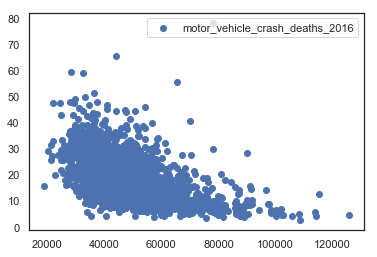

income_below_poverty_2016


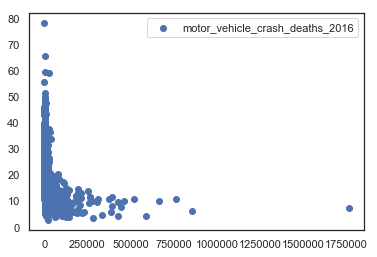

pop_poverty_status_2016


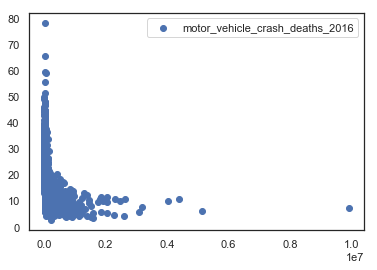

unemployment_2016


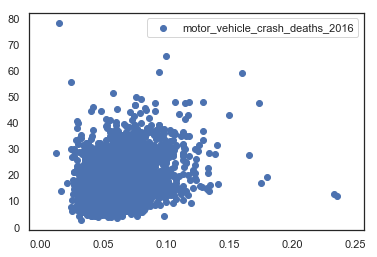

uninsured_2016


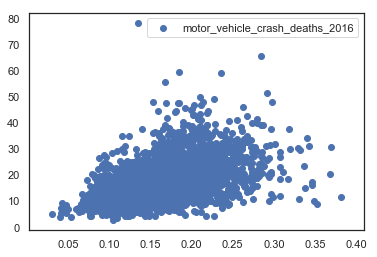

high_school_graduation_2016


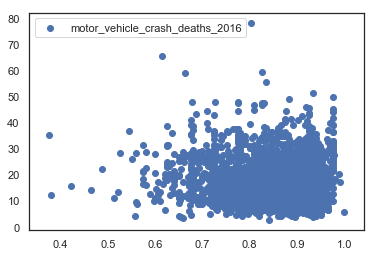

mean_commute_minutes_2016


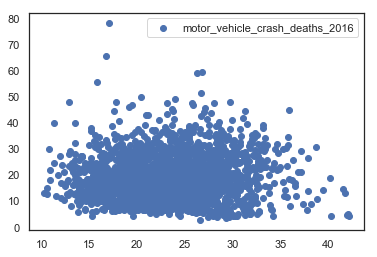

alcoholimpaired_driving_deaths_2016


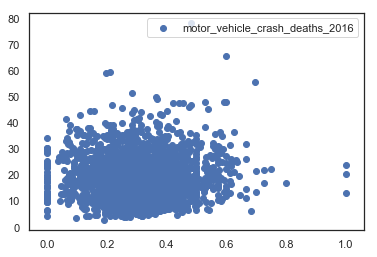

population_living_in_a_rural_area_2016


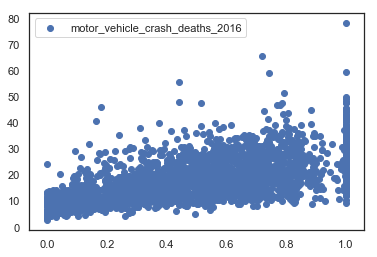

severe_housing_problems_2016


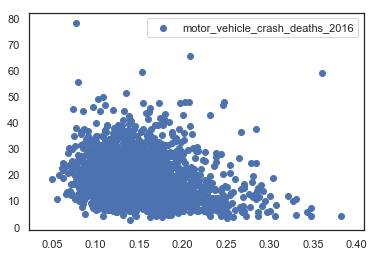

adult_obesity_2016


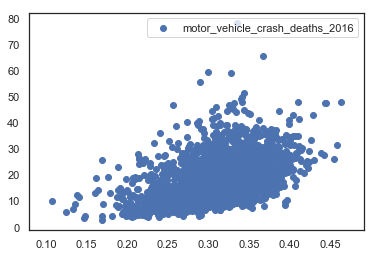

social_associations_2016


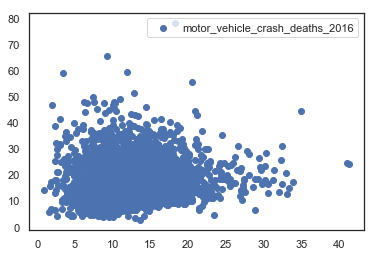

teen_births_2016


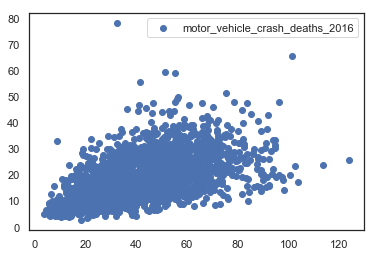

violent_crime_2016


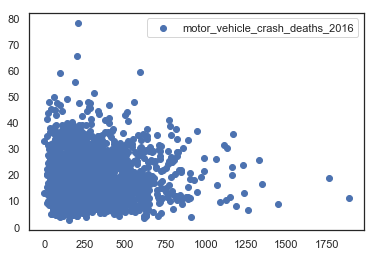

food_insecurity_2016


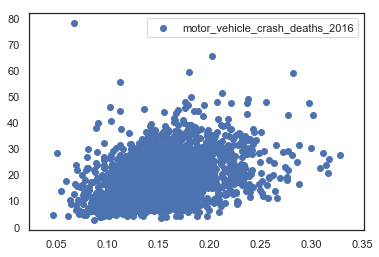

poor_mental_health_days_2016


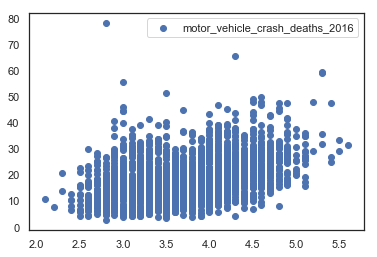

trumpy


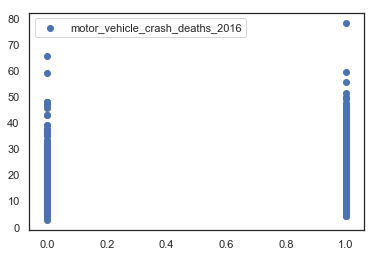

In [16]:
for column in features:
    plt.scatter(features[column], target)
    print(column)
    plt.legend()
    plt.show()

Mostly, probably, we think.

### Are we feelin linear?

In [17]:
# sns.pairplot(df) # This takes forever to run never run ever ever

### Is there multicolinearity?

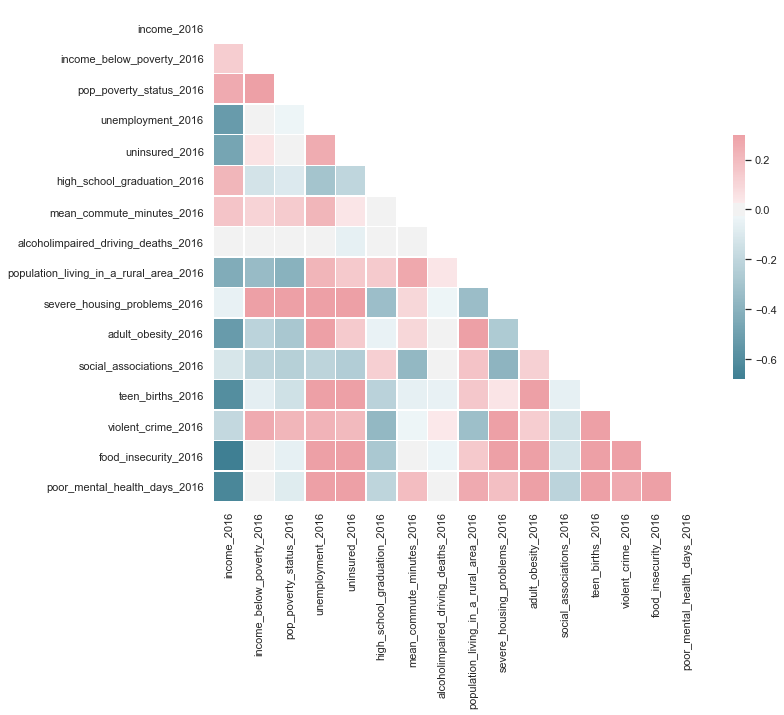

In [18]:
corr = features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Now we will split our training and test sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=39, test_size=0.2)

Just making some backups of our variables here for later down

In [20]:
X_train_orig = X_train 
X_test_orig = X_test
y_train_orig = y_train
y_test_orig = y_test

## Scaling Data

In [21]:
scaler = preprocessing.StandardScaler()

In [22]:
scaler.fit(features.iloc[:,:-1])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [23]:
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-1]), columns=X_train.columns[:-1], index=X_train.index)

features_scaled_train['trumpy']= X_train.trumpy
fst_train = features_scaled_train # making a backup for later

features_scaled_train.head()


income_2016  income_below_poverty_2016  pop_poverty_status_2016  \
1665     0.795095                   0.230420                 0.378970   
1054    -0.407368                  -0.138418                -0.178780   
1244    -1.496332                  -0.249995                -0.312155   
1794    -0.670059                   6.225366                 3.889770   
1077    -0.244947                  -0.175094                -0.226034   

      unemployment_2016  uninsured_2016  high_school_graduation_2016  \
1665          -1.339249       -0.112810                    -0.156857   
1054           0.458579       -0.673040                     0.331784   
1244           0.409989        0.119010                     0.665490   
1794           0.750118       -0.093491                    -1.467847   
1077          -0.610400       -0.518494                    -1.527437   

      mean_commute_minutes_2016  alcoholimpaired_driving_deaths_2016  \
1665                  -0.122079                            -0.095877   
1054                   1.258898                             0.667991   
1244                  -1.326618                            -0.876173   
1794                   1.741761                            -0.506559   
1077                  -0.931803                            -0.054809   

      population_living_in_a_rural_area_2016  severe_housing_problems_2016  \
1665                               -1.184874                     -0.230521   
1054                                1.160035                      0.409958   
1244                               -0.637614                      0.409958   
1794                               -1.770236                      2.212787   
1077                                0.553891                      0.386236   

      adult_obesity_2016  social_associations_2016  teen_births_2016  \
1665           -0.243168                 -0.932136         -1.053452   
1054            0.625032                  0.161314         -0.210115   
1244            0.491463                  0.970869          2.506087   
1794           -0.398999                 -0.983298          0.507269   
1077           -0.510306                 -0.256805          0.490840   

      violent_crime_2016  food_insecurity_2016  poor_mental_health_days_2016  \
1665            0.390230             -0.047675                      0.589772   
1054           -0.187228              0.137737                      0.245017   
1244            1.315115              1.674010                      1.279281   
1794            4.620953              1.568060                      1.796414   
1077            0.085816             -0.418500                     -0.789248   

     trumpy  
1665    1.0  
1054    1.0  
1244    1.0  
1794    0.0  
1077    1.0

In [24]:
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-1]), columns=X_test.columns[:-1], index=X_test.index)

features_scaled_test['trumpy']= X_test.trumpy
fst_test = features_scaled_test # Backup

features_scaled_test.head()


income_2016  income_below_poverty_2016  pop_poverty_status_2016  \
1365     4.684509                  -0.220884                -0.007590   
1553    -0.631705                  -0.011862                -0.122984   
794      0.811846                  -0.180809                -0.131284   
1938     0.250300                   0.157919                 0.172444   
378     -1.717694                  -0.277339                -0.327754   

      unemployment_2016  uninsured_2016  high_school_graduation_2016  \
1365          -0.853349       -1.793501                     1.285231   
1553           1.381787        0.601967                    -0.514400   
794           -0.270270       -0.634404                     0.081504   
1938           0.118449       -0.557130                     1.154132   
378            2.645125        0.621285                     0.975361   

      mean_commute_minutes_2016  alcoholimpaired_driving_deaths_2016  \
1365                   1.526726                            -0.416209   
1553                  -0.581444                             0.528359   
794                    0.852989                            -0.991164   
1938                   0.201380                            -0.186227   
378                    0.549101                            -1.024018   

      population_living_in_a_rural_area_2016  severe_housing_problems_2016  \
1365                               -0.052252                      0.386236   
1553                               -0.429793                      1.169044   
794                                -0.717278                     -0.942164   
1938                               -1.087892                     -0.135635   
378                                 0.363389                      1.809523   

      adult_obesity_2016  social_associations_2016  teen_births_2016  \
1365           -2.157660                 -0.491145         -2.093933   
1553            1.582278                 -0.231927          0.709889   
794             0.357893                 -1.131566         -0.571545   
1938           -0.398999                 -1.037469          0.036314   
378             1.114786                 -1.863275         -0.084162   

      violent_crime_2016  food_insecurity_2016  poor_mental_health_days_2016  \
1365           -1.109654             -2.140185                     -1.306380   
1553            0.760846              1.753472                      0.589772   
794            -0.770207             -0.789324                      0.072639   
1938            1.406414              0.349637                      1.106904   
378            -0.770106              3.263258                      1.279281   

     trumpy  
1365    1.0  
1553    1.0  
794     1.0  
1938    0.0  
378     0.0

## Baseline Regression

Just to get a feel for how we do with ALL variables accounted for:

In [25]:
outcome = 'motor_vehicle_crash_deaths_2016'
predictors = df.iloc[:,2:]
predictors
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum
model = ols(formula= formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     motor_vehicle_crash_deaths_2016   R-squared:                       0.600
Model:                                         OLS   Adj. R-squared:                  0.597
Method:                              Least Squares   F-statistic:                     214.4
Date:                             Thu, 06 Dec 2018   Prob (F-statistic):               0.00
Time:                                     21:47:40   Log-Likelihood:                -7545.9
No. Observations:                             2449   AIC:                         1.513e+04
Df Residuals:                                 2431   BIC:                         1.523e+04
Df Model:                                       17                                         
Covariance Type:                         nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                -10.0188      2.577     -3.888      0.000     -15.072      -4.966
trumpy[T.1.0]                             -0.3532      0.304     -1.162      0.245      -0.949       0.243
income_2016                             5.027e-05   1.87e-05      2.684      0.007    1.35e-05     8.7e-05
income_below_poverty_2016               -1.32e-05    8.5e-06     -1.554      0.120   -2.99e-05    3.46e-06
pop_poverty_status_2016                 1.649e-06   1.46e-06      1.128      0.260   -1.22e-06    4.52e-06
unemployment_2016                        -16.8463      7.830     -2.152      0.032     -32.199      -1.493
uninsured_2016                            31.0832      3.216      9.666      0.000      24.777      37.389
high_school_graduation_2016                1.9178      1.453      1.320      0.187      -0.931       4.767
mean_commute_minutes_2016                 -0.0168      0.030     -0.565      0.572      -0.075       0.041
alcoholimpaired_driving_deaths_2016        2.3806      0.889      2.677      0.007       0.637       4.125
population_living_in_a_rural_area_2016    14.2920      0.587     24.333      0.000      13.140      15.444
severe_housing_problems_2016             -18.0560      3.849     -4.691      0.000     -25.604     -10.508
adult_obesity_2016                         9.2800      3.466      2.677      0.007       2.483      16.077
social_associations_2016                   0.0645      0.027      2.385      0.017       0.011       0.118
teen_births_2016                           0.1443      0.010     15.002      0.000       0.125       0.163
violent_crime_2016                         0.0020      0.001      2.859      0.004       0.001       0.003
food_insecurity_2016                      22.7535      4.877      4.666      0.000      13.191      32.316
poor_mental_health_days_2016               0.5186      0.294      1.763      0.078      -0.058       1.095
==============================================================================
Omnibus:                      885.808   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7546.193
Skew:                           1.468   Prob(JB):                         0.00
Kurtosis:                      11.083   Cond. No.                     2.90e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+07. This might indicate that there are
strong multicollinearity or other num

We don't do so good.

## Improved Regression

That last model tells us which factors we might want to drop:

In [26]:
features_scaled_train = features_scaled_train.drop(['pop_poverty_status_2016',
                                                   'mean_commute_minutes_2016',
                                                   'high_school_graduation_2016',
                                                    'trumpy',
                                                    'poor_mental_health_days_2016'
                                                   ], axis=1)
features_scaled_test = features_scaled_test.drop(['pop_poverty_status_2016',
                                                   'mean_commute_minutes_2016',
                                                   'high_school_graduation_2016',
                                                    'trumpy',
                                                    'poor_mental_health_days_2016'], axis=1)

Let's now generate a bunch of crazy polynomial and interaction terms:

In [27]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
drunk_drivin_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
drunk_drivin_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))


Dropping some columns with low variance:

In [28]:
def variance_threshold_selector(data, threshold=.95):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features_selected_train = variance_threshold_selector(drunk_drivin_train)

In [29]:
print(len(drunk_drivin_train.columns))
len(features_selected_train.columns)

90


75

Now we're gonna look at some coefficients:

In [30]:
# Create correlation matrix
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

Now let's drop some colinear features:

In [31]:
features_selected_train.drop(columns=to_drop, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
len(features_selected_train.columns)

74

We can...pick the K most predictive features?

In [33]:
def information_selector(X, y, scoring, k):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [34]:
# test = SelectKBest(score_func=mutual_info_regression, k=64)
# fit = test.fit(features_selected_train, y_train)

In [35]:
features_selected_train = information_selector(features_selected_train, 
                                               y_train, mutual_info_regression, 
                                               k=10)


In [36]:
outcome = 'motor_vehicle_crash_deaths_2016'
predictors = features_scaled_train
pred_sum = "+".join(predictors.columns)

garbage = features_scaled_train
garbage['motor_vehicle_crash_deaths_2016'] = target
garbage

formula = outcome + "~" + pred_sum
model = ols(formula=formula, data=garbage).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     motor_vehicle_crash_deaths_2016   R-squared:                       0.590
Model:                                         OLS   Adj. R-squared:                  0.587
Method:                              Least Squares   F-statistic:                     232.9
Date:                             Thu, 06 Dec 2018   Prob (F-statistic):               0.00
Time:                                     21:47:42   Log-Likelihood:                -6059.5
No. Observations:                             1959   AIC:                         1.214e+04
Df Residuals:                                 1946   BIC:                         1.222e+04
Df Model:                                       12                                         
Covariance Type:                         nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 18.6072      0.121    153.778      0.000      18.370      18.844
income_2016                                0.6070      0.215      2.818      0.005       0.185       1.029
income_below_poverty_2016                 -0.2241      0.126     -1.772      0.077      -0.472       0.024
unemployment_2016                         -0.3112      0.169     -1.845      0.065      -0.642       0.020
uninsured_2016                             1.6203      0.187      8.674      0.000       1.254       1.987
alcoholimpaired_driving_deaths_2016        0.3240      0.120      2.695      0.007       0.088       0.560
population_living_in_a_rural_area_2016     4.0896      0.167     24.479      0.000       3.762       4.417
severe_housing_problems_2016              -0.7667      0.175     -4.391      0.000      -1.109      -0.424
adult_obesity_2016                         0.3920      0.169      2.314      0.021       0.060       0.724
social_associations_2016                   0.3678      0.141      2.602      0.009       0.091       0.645
teen_births_2016                           2.6161      0.201     13.018      0.000       2.222       3.010
violent_crime_2016                         0.3485      0.155      2.255      0.024       0.045       0.652
food_insecurity_2016                       0.9369      0.208      4.500      0.000       0.529       1.345
==============================================================================
Omnibus:                      752.782   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7017.396
Skew:                           1.541   Prob(JB):                         0.00
Kurtosis:                      11.745   Cond. No.                         4.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And build our model:

In [39]:
lm = linear_model.LinearRegression()
model_Ã… = lm.fit(features_selected_train, y_train)

In [40]:
features_selected_test = drunk_drivin_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

In [41]:
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE: ",metrics.mean_squared_error(y_test, y_pred))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE:  3.74633610564727
MSE:  25.882974326969105
RMSE:  5.087531260539743


Here's how we do:

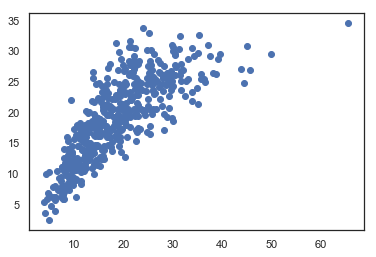

In [42]:
plt.scatter(y_test, y_pred)

## Lasso

In [43]:
from sklearn.linear_model import LassoCV

In [44]:
alphas = np.array(list(range(1,100)))/10000000
lassoReg = LassoCV(alphas=alphas, normalize=True)

lasso_xtrain = pd.DataFrame(poly.fit_transform(fst_train), columns=poly.get_feature_names(fst_train.columns))
lasso_xtest  = pd.DataFrame(poly.fit_transform(fst_test), columns=poly.get_feature_names(fst_test.columns))

lassoReg.fit(lasso_xtrain,y_train_orig)
y_pred = lassoReg.predict(lasso_xtest)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [45]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

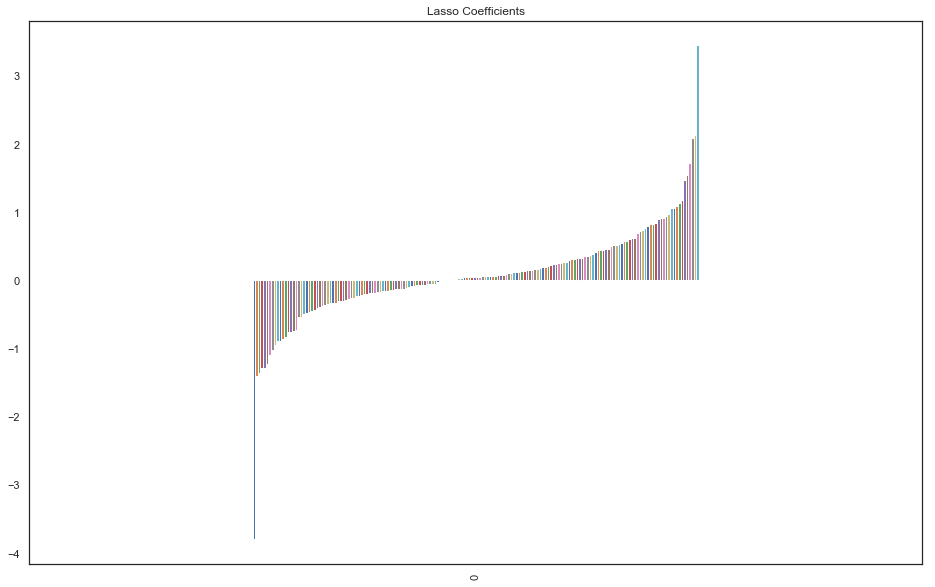

In [57]:
coef = pd.DataFrame(data = lassoReg.coef_, index=lasso_xtrain.columns)
model_coef = coef.sort_values(by=0).T
model_coef.plot(kind='bar', title='Lasso Coefficients', legend=False, figsize=(16,10))

In [47]:
lassoReg.score(lasso_xtrain, y_train_orig)

0.675476278144453

In [48]:
lassoReg.alpha_

9.9e-06

In [49]:
y_preds = lassoReg.predict(lasso_xtest)

In [50]:
lassoReg

LassoCV(alphas=array([1.0e-07, 2.0e-07, ..., 9.8e-06, 9.9e-06]), copy_X=True,
    cv='warn', eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=None, normalize=True, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

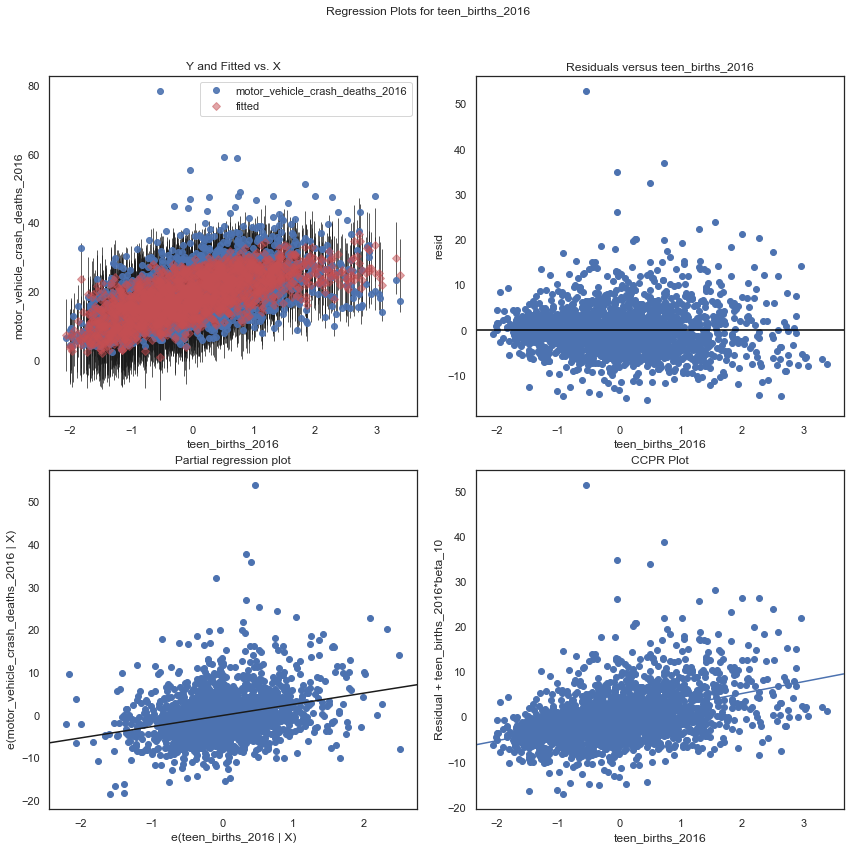

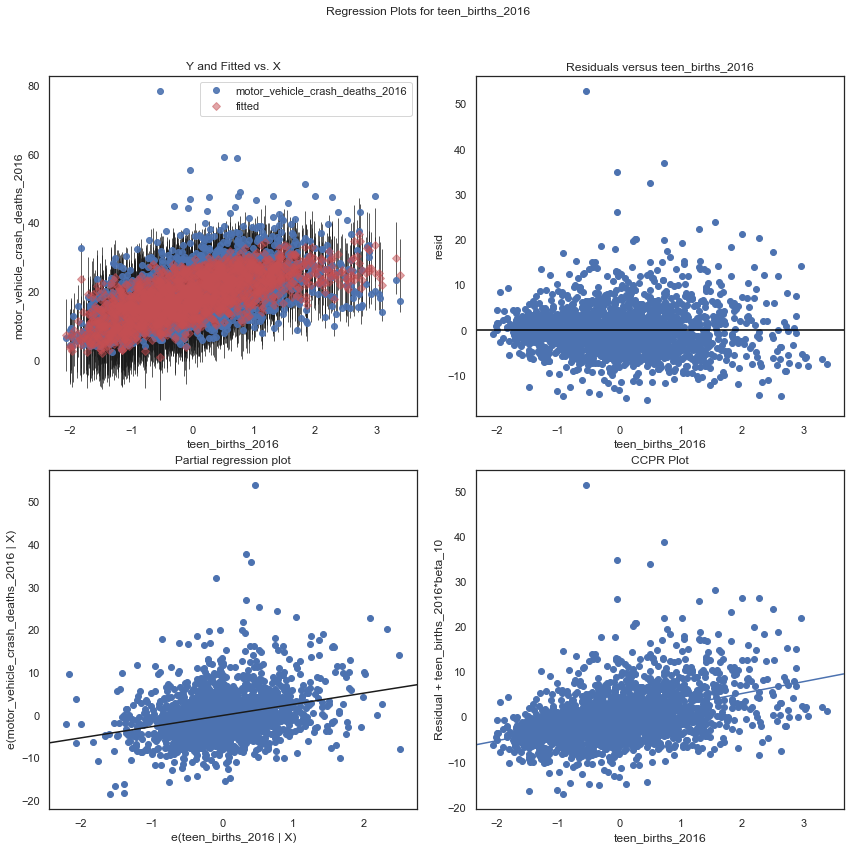

In [51]:
fig = plt.figure(figsize=(12,12))
sm.graphics.plot_regress_exog(model, "teen_births_2016", fig=fig)

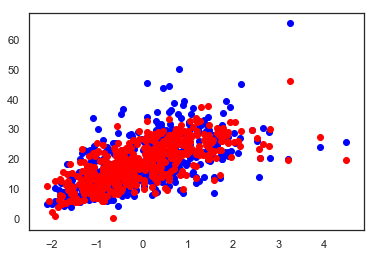

In [52]:
ax1 = plt.scatter(lasso_xtest['teen_births_2016'], y_test, c='blue')
ax2 = plt.scatter(lasso_xtest['teen_births_2016'], y_preds, c='red')